<a href="https://colab.research.google.com/github/shahshawaiz/hatespeach-group-identification/blob/master/hate_speach_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # # activate kaggle, mount grdive, download/unzip dataset
# import os
# import glob

# os.environ['KAGGLE_USERNAME'] = "shahshawaiz" # username from the json file
# os.environ['KAGGLE_KEY'] = "476e4fb10eef6d9da79358d4df0db985" # key from the json file

from google.colab import drive
drive.mount('/content/drive')

# # init consts
# PATH_HOME = "/content"
# PATH_GDRIVE = '/content/drive/My Drive/Colab Notebooks/dataset/hate-speach/train'
# FILE_TYPE = {
#     "1": "datasets",
#     "2": "competitions"
# }
# FILES = {
#     FILE_TYPE["1"] : [
#         "jdpaletto/glove-global-vectors-for-word-representation"
#     ],
#     FILE_TYPE["2"]: [
#         "jigsaw-unintended-bias-in-toxicity-classification"
#     ]
# }

# # iterate files and download
# for file_type, paths in FILES.items():
#   for path in paths:
#     try:
#       # move and delete
#       !kaggle "$file_type" download "$path"
      
#       archives = glob.glob("/content/*.zip")
#       for download in archives:
#         file_dir = download.strip('.zip')
#         !unzip -qq "$download"
#         !mv -n "$file_dir" "$PATH_GDRIVE"/
#         !mv -n "$file_dir"/ "$PATH_GDRIVE"/
#         !rm -rf "$download" "$file_dir"

#       non_archives = glob.glob("/content/*.txt") + glob.glob("/content/*.csv")
#       for download in non_archives:
#         !mv -n "$download" "$PATH_GDRIVE"/
#         !rm -rf "$download"


#     except OSError as e:
#       print("failed download: ", path, file)
#       pass

# # # drive.flush_and_unmount()   


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# pkgs installation
# !pip install tensorflow h5py pyyaml

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

import os

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras import backend as K
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.models import Model, Input
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Conv1D, Dropout, Activation, SpatialDropout1D, Bidirectional, CuDNNLSTM
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier


from keras.initializers import Constant
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
# set env
MODEL_VERSION = 'a'
PATH = '/content/drive/My Drive/Colab Notebooks/dataset/hate-speach'
PATH_GLOVE_100d = PATH + '/train/glove.twitter.27B.100d.txt'
PATH_TRAIN = PATH + '/train/train.csv'

In [5]:
# glove embeding routine
def get_glove_embedding():
    _embeddings_index = {}
    f = open(PATH_GLOVE_100d)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        _embeddings_index[word] = coefs
    f.close() 
    
    return _embeddings_index
    
embeddings_index = get_glove_embedding()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [6]:
# read csv
train=pd.read_csv(PATH_TRAIN)
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [0]:
# class dist
def plot_class_dist(df):
    plt.bar(range(0, len(df.columns.values)), df.sum().values, align='center')
    plt.ylabel('Classes')
    plt.title('Class Distribution')
    plt.show()    
    
def plot_class_dist_b(col_list):
    plt.bar(range(0, 4), col_list, align='center')
    plt.ylabel('Classes')
    plt.title('Class Distribution')
    plt.show() 

In [0]:
# resampling
def try_underSampling(train):
    
    #Prepare for under sampling 
    religion = train[(train.religion == 1)]
    print("target religion : ",religion.shape)
    ethnicity = train[(train.ethnicity == 1)]
    print("ethnicity: ",ethnicity.shape)
    sexualOrientation = train[(train.sexualOrientation == 1)]
    print("sexualOrientation: ",sexualOrientation.shape)
    gender = train[(train.sex == 1)]
    print("gender: ",gender.shape)
    no_hatespeech = train[(train.religion == 0) | (train.ethnicity == 0) | (train.sexualOrientation == 0) | (train.sex == 0)]
    print("No hatespeech : ",no_hatespeech.shape)
    all_together = train[(train.religion == 1) | (train.ethnicity == 1) | (train.sexualOrientation == 1) | (train.sex == 1)]
    
    religion = religion.sample(1189, replace=True)
    ethnicity = ethnicity.sample(1189, replace=True)
    sexualOrientation = sexualOrientation.sample(1189, replace=True)
    gender = gender.sample(1189, replace=True)
    no_hatespeech = no_hatespeech.sample(1189, replace=True)
    all_together = all_together.sample(1189, replace=True)

    print("New target religion : ",religion.shape)
    print("New ethnicity: ", ethnicity.shape)
    print("New sexualOrientation: ",sexualOrientation.shape)
    print("New gender: ",gender.shape)
    print("New No hatespeech : ",no_hatespeech.shape)
    print("All : ",all_together.shape)
    
    train_set = pd.concat([religion, ethnicity, sexualOrientation, gender, no_hatespeech])
    train_set = train_set[['id', 'target', 'comment_text', 'religion','ethnicity','sexualOrientation', 'sex', 'tags']]
    
    return train_set, [religion.shape[0], ethnicity.shape[0], sexualOrientation.shape[0], gender.shape[0]]

In [0]:
# one hot encoding routine
def one_hot_encode_by_label(dataset, new_col, col_list, threshold_val=0.1):
    
    for col in col_list:
        dataset[new_col] = (
            dataset[col] > threshold_val
        )*1.0  
    return dataset

# encode all column/groups
religions = [
    'atheist',
    'buddhist',
    'christian',
    'hindu',
    'jewish',
    'muslim',
    'other_religion'
]
train = one_hot_encode_by_label(train, 'religion', religions)

#
ethnicity = [
    'asian',
    'black',
    'latino',
    'white',
    'other_race_or_ethnicity'
]
train = one_hot_encode_by_label(train, 'ethnicity', ethnicity)

# 
sexualOrientation = [
    'bisexual',
    'heterosexual',
    'homosexual_gay_or_lesbian',
    'transgender',
    'other_sexual_orientation'    
]
train = one_hot_encode_by_label(train, 'sexualOrientation', sexualOrientation)

#
sex = [
    'male',
    'female',
    'other_gender' 
]

# run one hot encoding
train = one_hot_encode_by_label(train, 'sex', sex)

In [0]:
# add tag column
train["tags"] = 0
train["tags"] = train.apply(lambda x: x['tags'] if x['religion']==0 else x['religion']*0, axis=1)
train["tags"] = train.apply(lambda x: x['tags'] if x['ethnicity']==0 else x['ethnicity']*1, axis=1)
train["tags"] = train.apply(lambda x: x['tags'] if x['sexualOrientation']==0 else x['sexualOrientation']*2, axis=1)
train["tags"] = train.apply(lambda x: x['tags'] if x['sex']==0 else x['sex']*3, axis=1) 

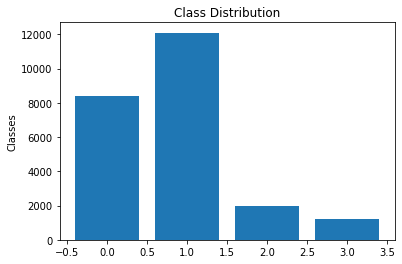

target religion :  (8404, 50)
ethnicity:  (12094, 50)
sexualOrientation:  (1953, 50)
gender:  (1189, 50)
No hatespeech :  (22679, 50)
New target religion :  (1189, 50)
New ethnicity:  (1189, 50)
New sexualOrientation:  (1189, 50)
New gender:  (1189, 50)
New No hatespeech :  (1189, 50)
All :  (1189, 50)


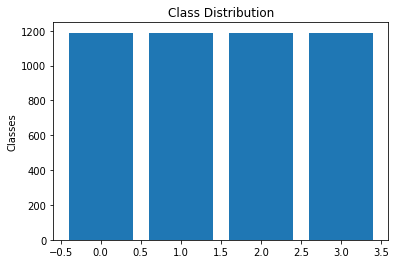

,id,target,comment_text,religion,ethnicity,sexualOrientation,sex,tags
674625,1066858,0.3,"""Looking at our surveys over time, it has beco...",0.0,0.0,1.0,0.0,2.0
1650464,6145087,0.2,He's the Commander in Chief of the Armed Servi...,0.0,1.0,0.0,0.0,1.0
231655,526268,0.0,I think we need to consider Hillary Clinton's ...,0.0,0.0,1.0,0.0,2.0
733375,5018988,0.0,People don't want to be priests in general. Op...,1.0,0.0,0.0,0.0,0.0
52117,305950,0.0,True dat. Here's another conundrum: why do we ...,0.0,0.0,1.0,0.0,2.0


In [11]:
# filter data with only hate comments
train=train[(train.religion == 1) | (train.ethnicity == 1) | (train.sexualOrientation == 1) | (train.sex == 1)]


# run resampling
plot_class_dist(train[['religion','ethnicity','sexualOrientation', 'sex']])
train, sample_shape = try_underSampling(train)

train[['religion','ethnicity','sexualOrientation', 'sex']].sum(axis=0).values

plot_class_dist_b(sample_shape)

# 
train.tail()

In [0]:
# x,y sepration
X = train['comment_text']
y = train[['religion','ethnicity','sexualOrientation', 'sex']]
train.columns
y2 = train['tags']

# # train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, stratify=y2, test_size=0.2, random_state=42)

In [0]:
y_train = y_train[[ 'religion','ethnicity','sexualOrientation', 'sex']].values
y_test = y_test[[ 'religion','ethnicity','sexualOrientation', 'sex']].values

In [0]:
# init vars
max_features = 20000  # number of words we want to keep
maxlen = 200  # max length of the comments in the model
batch_size = 64  # batch size for the model
embedding_dims = 100  # dimension of the hidden variable, i.e. the embedding dimension
epochs = 10

In [15]:
# init tkenizer
tok = Tokenizer(num_words=max_features)

X_train_org = X_train
X_test_org = X_test

# fit train/test comments over tokenizer
tok.fit_on_texts(list(X_train) + list(X_test))

# convert text to sequence
x_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(X_test)

# debug
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

4756 train sequences
1189 test sequences
Average train sequence length: 74
Average test sequence length: 70


In [16]:
word_index = tok.word_index
print('Found %s unique tokens.' % len(word_index))

num_words = min(max_features, len(word_index)) + 1
print(num_words)

# init embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dims))

# for every word token, get vector from glove embeding vecotr (from w2v model)
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dims)

Found 23732 unique tokens.
20001


In [0]:
# 
y_train=y_train[:1209265,:]
y_test=y_test[:1209265,:]

In [18]:
# pad sequences to get equal length vector/comments
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print(x_train)

x_train shape: (4756, 200)
x_test shape: (1189, 200)
[[   0    0    0 ...   49  277 1227]
 [   0    0    0 ...   84   13   50]
 [   0    0    0 ...  699   31   13]
 ...
 [   0    0    0 ...  227    9   54]
 [   0    0    0 ...  375    9   12]
 [   0    0    0 ...    3   25  180]]


In [0]:
# f1 score routine
def f1_score_b(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# confusion matrix routine
def get_confusion_matrix(model, x_test, y_true):
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5) #greater than 0.50 on scale 0 to 1

    from sklearn.metrics import classification_report
    return classification_report(y_true, y_pred)

In [0]:
# lstm bidirectional with glove embeding model creation 
def create_model_feedforward(
    f1_score=f1_score_b,
    n_input=5,
    n_output=4,    
    output_activation='softmax', 
    loss='binary_crossentropy', 
    optimizer='adam'
):
    
    # model init
    model = Sequential()
    
    # layer embeding     
    model.add(
        Embedding(
            max_features, 
            embedding_dims, 
            input_length=maxlen, 
            embeddings_initializer="uniform"
        )
    )
    
    # layer pooling for dim reducntion
    model.add(
        GlobalMaxPooling1D()
    )
    
    #      
    model.add(
        Dense(n_input, activation='relu')
    )
    
    # output     
    model.add(
        Dense(n_output, activation=output_activation)
    )

    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy', f1_score])
    
    return model

In [22]:
model1 = create_model_feedforward()
model1.summary()

history_ff = model1.fit(x_train, y_train, verbose=1, epochs=epochs)

print(get_confusion_matrix(model1,x_train, y_train))

# print(X_test)
# X_test = tok.texts_to_sequences(X_test)
# dat_test = pd.DataFrame(["taking jobs", "muslims", "jews", "christians", "muslims are evil people", "jews are stupid"], columns = ['comment_text'])['comment_text']
# dat_test_test1 = tok.texts_to_sequences(dat_test)
# x_test_1 = sequence.pad_sequences(dat_test_test1, maxlen=maxlen)
# y_pred = model1.predict(x_test_1)
# # y_pred_df = pd.DataFrame(y_pred)

# model1_f1 = f1_score(y_test, y_pred, average='weighted')
# model1_acc = accuracy_score(y_test2, y_pred2, normalize=True)
# print('f1:', model1_f1, 'acc', model1_acc)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 24        
Total params: 2,000,529
Trainable params: 2,000,529
Non-trainable params: 0
_________________________________________________________________



Epoch 1/10





4756/4756 [==============================] - 6s 1ms/step - loss: 0.5915 - acc: 0.7179 - f1_score_b: 0.0000e+00
Epoch 2/10
47

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# lstm bidirectional with glove embeding model creation 
def create_model_org_lstm_bidir_glove(
    f1_score=f1_score_b,
    n1_lstm=64,
    n2_lstm=32,
    n_output=4,
    spatial_dropout=0.2, 
    pre_output_dropout=0.25, 
    output_neurons=4, 
    output_activation='softmax', 
    loss='categorical_crossentropy', 
    optimizer='adam'):
    
    # init model
    model = Sequential()
    
    # layer embeding
    model.add(Embedding(
        num_words, 
        embedding_dims, 
        input_length=maxlen,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=True        
    ))

    # layer dropout for gerneralizatoin (drops entire 1D feature maps instead of individual elements)
    model.add(SpatialDropout1D(spatial_dropout))
    
    # Bidirectional: ?,   CuDNNLSTM: better/fast implementation of LSTM
    model.add(Bidirectional(CuDNNLSTM(n1_lstm, return_sequences=True)))
    
    #     
    model.add(Bidirectional(CuDNNLSTM(n2_lstm)))
    
    # 
    model.add(Dropout(pre_output_dropout))
    
    # layer output
    model.add(Dense(units=4, activation=output_activation))
    
    model.compile(loss=loss,
          optimizer=optimizer,
          metrics=['accuracy', f1_score])
    
    return model

In [0]:
# #  lstm bidirectional with glove embeding compilation and fitting
# model2 = create_model_org_lstm_bidir_glove()
# model2.summary()
# history_lstm = model2.fit(x_train, y_train, verbose=1, epochs=10)

# print(get_confusion_matrix(model2,x_train, y_train))

# path_write = os.path.join('../input/','model2.h5')
# print(path_write)

# outp = model2.save(path_write)
# print(outp)

In [0]:
#NB implementation
def create_naive_bayes():

#     tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
#     features = tfidf.fit_transform(train.comment_text).toarray()

    model = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                  ])
    return model

In [26]:
#  nb
model3 = create_naive_bayes()
model3.fit(X_train2, y_train2)

# f2 score
y_pred2 = model3.predict(X_test2)
model3_f1 = f1_score(y_test2, y_pred2, average="weighted")
model3_acc = accuracy_score(y_test2, y_pred2, normalize=True)
print('f1:', model3_f1, 'acc', model3_acc)

f1: 0.5114151782924601 acc 0.5508830950378469


In [0]:
# svm implementation
def create_svm():
    
    model = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2')) # hinge loss functino for linear SVM
    ])

    return model

In [28]:
# acm
model4 = create_svm()
model4.fit(X_train2, y_train2)

# f2 score
y_pred2 = model4.predict(X_test2)
model4_f1 = f1_score(y_test2, y_pred2, average='weighted')
model4_acc = accuracy_score(y_test2, y_pred2, normalize=True)
print('f1:', model4_f1, 'acc', model4_acc)

f1: 0.7137488960807645 acc 0.7140454163162321


In [0]:
# # testing predictions
# y_precit = model2.predict(x_test)
# len(x_test), y_test, len(y_test), y_precit

In [30]:
# examples: religion','ethnicity','sexualOrientation', 'sex']

dat_test = pd.DataFrame(["muslims", "jews", "christians", "muslims are evil people", "jews are stupid"], columns = ['comment_text'])['comment_text']
dat_test = tok.texts_to_sequences(dat_test)
dat_test = sequence.pad_sequences(dat_test, maxlen=maxlen)
y_pred = model1.predict(dat_test)
y_pred_df = pd.DataFrame(y_pred)
print('relgion (1)', y_pred_df)

dat_test = pd.DataFrame(["immigrants are taking jobs", "immigrants should go back", "i hate color black", "i hate color white", "chinese are stupid"], columns = ['comment_text'])['comment_text']
dat_test = tok.texts_to_sequences(dat_test)
dat_test = sequence.pad_sequences(dat_test, maxlen=maxlen)
y_pred = model1.predict(dat_test)
y_pred_df = pd.DataFrame(y_pred)
print('ethinicity (2)', y_pred_df)


dat_test = pd.DataFrame(["bisexual", "gay", "lesbian", "i hate homosexuals", "transgenders are stupid"], columns = ['comment_text'])['comment_text']
dat_test = tok.texts_to_sequences(dat_test)
dat_test = sequence.pad_sequences(dat_test, maxlen=maxlen)
y_pred = model1.predict(dat_test)
y_pred_df = pd.DataFrame(y_pred)
print('sexual orientation (3)', y_pred_df)

dat_test = pd.DataFrame(["women", "men", "feminism", "Kill woman society", "Bloddy female group"], columns = ['comment_text'])['comment_text']
dat_test = tok.texts_to_sequences(dat_test)
dat_test = sequence.pad_sequences(dat_test, maxlen=maxlen)
y_pred = model1.predict(dat_test)
y_pred_df = pd.DataFrame(y_pred)
print('gender (4)', y_pred_df)

relgion (1)           0         1         2         3
0  0.052690  0.044532  0.484081  0.418697
1  0.069367  0.064700  0.405381  0.460551
2  0.205741  0.013537  0.521584  0.259138
3  0.107090  0.056384  0.295459  0.541067
4  0.035035  0.014940  0.505189  0.444837
ethinicity (2)           0         1         2         3
0  0.074356  0.566541  0.074653  0.284450
1  0.066908  0.413013  0.093524  0.426555
2  0.115317  0.188871  0.482147  0.213665
3  0.130014  0.326274  0.227751  0.315960
4  0.018255  0.212176  0.026043  0.743526
sexual orientation (3)           0         1         2         3
0  0.095277  0.267994  0.087695  0.549034
1  0.083357  0.006154  0.598216  0.312274
2  0.020498  0.001515  0.856634  0.121354
3  0.052466  0.017624  0.367891  0.562019
4  0.032760  0.008497  0.309453  0.649290
gender (4)           0         1         2         3
0  0.200359  0.057038  0.385332  0.357271
1  0.182102  0.075817  0.362646  0.379435
2  0.413099  0.109319  0.194004  0.283578
3  0.109674  0.

In [0]:
# # examples: religion','ethnicity','sexualOrientation', 'sex']

# dat_test = pd.DataFrame(["muslims", "jews", "christians", "muslims are evil people", "jews are stupid"], columns = ['comment_text'])['comment_text']
# dat_test = tok.texts_to_sequences(dat_test)
# dat_test = sequence.pad_sequences(dat_test, maxlen=maxlen)
# y_pred = model2.predict(dat_test)
# y_pred_df = pd.DataFrame(y_pred)
# print('relgion (1)', y_pred_df)

# dat_test = pd.DataFrame(["immigrants are taking jobs", "immigrants should go back", "i hate color black", "i hate color white", "chinese are stupid"], columns = ['comment_text'])['comment_text']
# dat_test = tok.texts_to_sequences(dat_test)
# dat_test = sequence.pad_sequences(dat_test, maxlen=maxlen)
# y_pred = model2.predict(dat_test)
# y_pred_df = pd.DataFrame(y_pred)
# print('ethinicity (2)', y_pred_df)


# dat_test = pd.DataFrame(["bisexual", "gay", "lesbian", "i hate homosexuals", "transgenders are stupid"], columns = ['comment_text'])['comment_text']
# dat_test = tok.texts_to_sequences(dat_test)
# dat_test = sequence.pad_sequences(dat_test, maxlen=maxlen)
# y_pred = model2.predict(dat_test)
# y_pred_df = pd.DataFrame(y_pred)
# print('sexual orientation (3)', y_pred_df)

# dat_test = pd.DataFrame(["women", "men", "feminism", "Kill woman society", "Bloddy female group"], columns = ['comment_text'])['comment_text']

In [32]:
# Model 1 HP grid space
n_input=[5,10,15]
n_output=[4] 
output_activation = ['softmax', 'relu', 'sigmoid']
optimizer = ['adam', 'sgd']
loss=['binary_crossentropy']

# # hyperparamter gird space
hyperparamter_space = dict(
#     n_input=n_input,
#     n_output=n_output,
    output_activation=output_activation,
	optimizer=optimizer,
# 	loss=loss,
)

# hyperparamter optimization using scikit learn GridSearch CV
def optimize_hyperparamters(build_fn, x_train, y_train, hyperparamter_space=hyperparamter_space):

    # init classifier
    model = KerasClassifier(
        build_fn=build_fn, verbose=0
    )

    # gridsearch using hyperparamer space        
    grid = GridSearchCV(
        estimator=model, 
        param_grid=hyperparamter_space, 
        cv=3
    )

    # model fitting        
    grid_result = grid.fit(
        x_train, 
        y_train
    )
    # print best fit 
    print("Best Params: %s; Score: %f" % (grid_result.best_params_, grid_result.best_score_))

    means = grid_result.cv_results_['mean_test_score']
    params = grid_result.cv_results_['params']

    # print all combinations
    for mean, param in zip(means, params):
        print("%f @ %r" % (mean, param))

    return grid_result.best_params_

# get optimized hyperparamter combination
best_params = optimize_hyperparamters(
    create_model_feedforward,
    x_train, 
    y_train
)

Best Params: {'optimizer': 'adam', 'output_activation': 'softmax'}; Score: 0.717935
0.717935 @ {'optimizer': 'adam', 'output_activation': 'softmax'}
0.717935 @ {'optimizer': 'adam', 'output_activation': 'relu'}
0.695552 @ {'optimizer': 'adam', 'output_activation': 'sigmoid'}
0.717935 @ {'optimizer': 'sgd', 'output_activation': 'softmax'}
0.717935 @ {'optimizer': 'sgd', 'output_activation': 'relu'}
0.717935 @ {'optimizer': 'sgd', 'output_activation': 'sigmoid'}


In [0]:
# # # lstm bidirectional with glove embeding model creation 
# # Model 2 HP grid space
# # optimizer = ['softmax','adam', 'sgd']
# n1_lstm = [32, 64]
# n2_lstm = [64, 96]
# # n_input=[5,10,15]
# # spatial_dropout=[0.2, 0.4, 0.6]
# # pre_output_dropout=[0.25, 0.45, 0.65],   
# # output_neurons = [4]
# # output_activation = ['softmax','relu', 'sigmoid']
# # optimizer = ['adam', 'sgd']
# # loss=['binary_crossentropy']

# # # hyperparamter gird space
# hyperparamter_space = dict(
#     n1_lstm=n1_lstm,
#     n2_lstm=n2_lstm,
# #     spatial_dropout=spatial_dropout,
# #     pre_output_dropout=pre_output_dropout
# )

# # hyperparamter optimization using scikit learn GridSearch CV
# def optimize_hyperparamters(build_fn, x_train, y_train, hyperparamter_space=hyperparamter_space):

#     # init classifier
#     model = KerasClassifier(
#         build_fn=build_fn, verbose=0
#     )

#     # gridsearch using hyperparamer space        
#     grid = GridSearchCV(
#         estimator=model, 
#         param_grid=hyperparamter_space, 
#         cv=3
#     )

#     # model fitting        
#     grid_result = grid.fit(
#         x_train, 
#         y_train
#     )
#     # print best fit 
#     print("Best Params: %s; Score: %f" % (grid_result.best_params_, grid_result.best_score_))

#     means = grid_result.cv_results_['mean_test_score']
#     params = grid_result.cv_results_['params']

#     # print all combinations
#     for mean, param in zip(means, params):
#         print("%f @ %r" % (mean, param))

#     return grid_result.best_params_

# # get optimized hyperparamter combination
# best_params = optimize_hyperparamters(
#     create_model_org_lstm_bidir_glove,
#     x_train, 
#     y_train
# )

In [0]:
# # training history
# df=pd.DataFrame({
#     'epoch': range(0,history_lstm.params['epochs']), 
#     'm1': history_lstm.history['f1_score_b'], 
#     'm2': history_ff.history['f1_score_b']
# })
 
# plt.plot( 'epoch', 'm1', data=df, marker='', color='red', linewidth=2)
# plt.plot( 'epoch', 'm2', data=df, marker='', color='blue', linewidth=2)

# plt.title('Training History')
# plt.ylabel('F1')
# plt.xlabel('Epoch')
# plt.legend(['FF', 'LSTM'], loc='upper left')
# plt.show()


In [0]:
# # ROC/AOC curve
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
# roc_auc = auc(false_positive_rate, true_positive_rate)